<a href="https://colab.research.google.com/github/luccaviccini/PL-Unico/blob/main/Estudo_PLUnico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações

In [ ]:
lista_uhe = [
    {
        "Nome": "UHE DO FOGAO",  # Nome da Usina
        "Vmax": 200.,             # Volume Máximo em hm^3
        "Vmin": 20.,              # Volume Mínimo em hm^3
        "VI": 100,                # Volume Inicial em hm^3
        "Prod": 0.95,             # Produtibilidade em MWmed/hm^3
        "Engol": 60.,             # Engolimento Máximo em hm^3
        "Afl": [                  # Cenários de Afluências (linha: Estágio, coluna: cenário)
            [16, 16],
            [16, 16],
            [16, 16],
            [16, 16],
            [16, 16],
            [16, 16]
        ]
    }
]



lista_ute = [
    {
        "Nome": "GT_1",     # Nome da Usina Térmica 1
        "Capac": 15.,       # Capacidade Máxima de Geração MWMed
        "Custo": 10.        # Custo de Operação $/MWMed
    },
    {
        "Nome": "GT_2",     # Nome da Usina Térmica 2
        "Capac": 10.,       # Capacidade Máxima de Geração MWmed
        "Custo": 25.        # Custo de Operação $/MWMed
    }

]


d_gerais = {
    "CDef": 500.,             # Custo de Déficit $/MWMed
    "Carga": [50.]*6,  # Lista com carga a ser atendida por estágio
    "Nr_Disc": 30,            # Número de Discretizações
    "Nr_Est": 6,              # Número de Estágios
    "Nr_Cen": 2               # Número de Cenários de Afluências
}


#
# Cria dicionário de dados com todas as informações do sistema em estudo
#
sistema = {
    "DGer": d_gerais,
    "UHE": lista_uhe,
    "UTE": lista_ute
}


# PL Único


In [ ]:
from cvxopt.modeling import variable, solvers
from cvxopt.modeling import op
import time
import numpy as np
import matplotlib.pyplot as plt


def pl_unico(sistema, cenario, imprime):
  solvers.options['show_progress'] = False
  # Cria função de despacho hidrotérmico
  Num_UHE = len(sistema["UHE"])
  Num_UTE = len(sistema["UTE"])

  # Cria Variáveis de Decisão Organizadas Matricialmente
  vf = []
  vt = []
  vv = []

  for i, iusi in enumerate(sistema["UHE"]):
    vf.append(variable(sistema["DGer"]["Nr_Est"],
              "Volume Final na Usina "+iusi["Nome"]))
    vt.append(variable(sistema["DGer"]["Nr_Est"],
              "Volume Turbinado na Usina "+iusi["Nome"]))
    vv.append(variable(sistema["DGer"]["Nr_Est"],
              "Volume Vertido na Usina "+iusi["Nome"]))
  gt = []

  for i, iusi in enumerate(sistema["UTE"]):
    gt.append(variable(sistema["DGer"]["Nr_Est"],
              "Geração na Usina Térmica "+iusi["Nome"]))
  deficit = variable(sistema["DGer"]["Nr_Est"],
                     "Déficit de Energia no Sistema")

  # Construção da Função Objetivo
  fob = 0

  for i_est in range(sistema["DGer"]["Nr_Est"]):
    for i, iusi in enumerate(sistema["UTE"]):
      fob += iusi['Custo']*gt[i][i_est]

    fob += sistema["DGer"]["CDef"]*deficit[i_est]

    for i, iusi in enumerate(sistema["UHE"]):
      fob += 0.01*vv[i][i_est]

  # Definição das Restrições
  restricoes = []

  # Balanço Hídrico
  for i, iusi in enumerate(sistema["UHE"]):  # percorre a lista de UHE
    for i_est in range(sistema["DGer"]["Nr_Est"]):
      if i_est == 0:
        restricoes.append(vf[i][i_est] == float(
            iusi["VI"]) + float(iusi["Afl"][i_est][cenario]) - vt[i][i_est] - vv[i][i_est])
      else:
        restricoes.append(vf[i][i_est] == vf[i][i_est-1] +
                          float(iusi["Afl"][i_est][cenario]) - vt[i][i_est] - vv[i][i_est])

  # Atendimento à Demanda
  for i_est in range(sistema["DGer"]["Nr_Est"]):
    AD = 0
    for i, usi in enumerate(sistema["UHE"]):
      AD += iusi["Prod"]*vt[i][i_est]
    for i, usi in enumerate(sistema["UTE"]):
      AD += gt[i][i_est]
    AD += deficit[i_est]
    restricoes.append(AD == sistema["DGer"]["Carga"][i_est])

  # Restricoes Canalização
  for i_est in range(sistema["DGer"]["Nr_Est"]):
    for i, iusi in enumerate(sistema["UHE"]):
      restricoes.append(vf[i][i_est] >= iusi["Vmin"])
      restricoes.append(vf[i][i_est] <= iusi["Vmax"])
      restricoes.append(vt[i][i_est] >= 0)
      restricoes.append(vt[i][i_est] <= iusi["Engol"])
      restricoes.append(vv[i][i_est] >= 0)
    for i, iusi in enumerate(sistema["UTE"]):
      restricoes.append(gt[i][i_est] >= 0)
      restricoes.append(gt[i][i_est] <= iusi["Capac"])
    restricoes.append(deficit[i_est] >= 0)

  # Cria problema de otimização
  tInicial = time.time()
  problema = op(fob, restricoes)

  # Chama solver GLPK e resolve o problema de otimização linear
  problema.solve('dense', 'glpk')

  tFinal = time.time() - tInicial

  # Prepara dicionário de dados com resultados
  lista_uhe = []
  for i, iusi in enumerate(sistema["UHE"]):
    pula = i*sistema["DGer"]["Nr_Est"]
    cma = []
    volf = []
    volt = []
    volv = []
    for iest in range(sistema["DGer"]["Nr_Est"]):
      cma.append(restricoes[pula+i_est].multiplier.value[0])
      volf.append(vf[i][iest].value()[0])
      volt.append(vt[i][iest].value()[0])
      volv.append(vv[i][iest].value()[0])
    elemento = {
        "vf": volf,
        "vt": volt,
        "vv": volv,
        "cma": cma
    }
    lista_uhe.append(elemento)

  lista_ute = []
  for i, iusi in enumerate(sistema["UTE"]):
    gerter = []
    for iest in range(sistema["DGer"]["Nr_Est"]):
      gerter.append(gt[i][iest].value()[0])
    elemento = {
        "gt": gerter,
    }
    lista_ute.append(elemento)

  pula = Num_UHE*sistema["DGer"]["Nr_Est"]
  cmo = []
  for i_est in range(sistema["DGer"]["Nr_Est"]):
    cmo.append(restricoes[pula+i_est].multiplier.value[0])

  Dger = {
      "CustoTotal": fob.value()[0],
      "CMO": cmo
  }

  resultado = {
      "DGer": Dger,
      "UHE": lista_uhe,
      "UTE": lista_ute,
      "Tempo": tFinal
  }

  #
  # Imprime resultados em tela
  #

  if imprime:
    print("\n\n--------------- RESULTADO DO PL ÚNICO -----------------")
    print("Tempo de execução: {:.5f} segundos".format(tFinal))
    print("\n\nCusto de Operação de Todos os estágios: R${:.2f}".format(
        fob.value()[0]))

    print("\nVolume Final por UHE em cada Estágio (hm^3):")
    for i, usi in enumerate(sistema["UHE"]):
      print("\nUHEid: {}: Volume Final = {},\n Volume Turbinado = {},\n Volume Vertido = {}".format(
          usi["Nome"],
          ['{:.2f}'.format(round(float(v), 2)) for v in vf[i].value],
          ['{:.2f}'.format(round(float(v), 2)) for v in vt[i].value],
          ['{:.2f}'.format(round(float(v), 2)) for v in vv[i].value]
      ))

    print("\nGeração por UTE em cada Estágio (MWMed):")
    for i, usi in enumerate(sistema["UTE"]):
      geracao = ['{:.2f}'.format(round(float(g), 2)) for g in gt[i].value]
      print("UTE {}: Geração = {}".format(usi["Nome"], geracao))

    print("\nDéficit de Energia em cada Estágio (MWMed): {}".format(
        ['{:.2f}'.format(round(float(d), 2)) for d in deficit.value]))

    print("Tempo de execução: {:.5f} segundos".format(tFinal))

    print("\n----- x ------ ")
  if imprime:
      # ... (código de impressão anterior)

      x = np.arange(0, sistema['DGer']['Nr_Est'], 1)
      plt.figure(figsize=(10,8))

      for i, iusi in enumerate(resultado["UHE"]):
          plt.plot(x+1, iusi['vf'], marker='d', label=sistema["UHE"][i]["Nome"])
      plt.title('Evolução do Volume Armazenado Final (hm^3)')
      plt.xlabel('Período ou Mês de Planejamento')
      plt.ylabel('Volume Armazenado (hm^3)')
      plt.xticks(x+1)
      plt.legend()
      plt.grid()
      plt.tight_layout()


      plt.figure(figsize=(10,8))

      for i, iusi in enumerate(resultado["UTE"]):
          plt.plot(x+1, iusi['gt'], marker='d', label=sistema["UTE"][i]["Nome"])
      plt.title('Evolução da Geração Térmica nas UTEs (MWmed)')
      plt.xlabel('Período ou Mês de Planejamento')
      plt.ylabel('Geração (MWmed)')
      plt.xticks(x+1)
      plt.legend()
      plt.grid()
      plt.tight_layout()
      #plt.show()



  return(resultado)


# Principal



--------------- RESULTADO DO PL ÚNICO -----------------
Tempo de execução: 0.03813 segundos


Custo de Operação de Todos os estágios: R$1970.00

Volume Final por UHE em cada Estágio (hm^3):

UHEid: UHE DO LUCCA: Volume Final = ['79.16', '61.26', '50.95', '40.63', '30.32', '20.00'],
 Volume Turbinado = ['36.84', '33.89', '26.32', '26.32', '26.32', '26.32'],
 Volume Vertido = ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00']

Geração por UTE em cada Estágio (MWMed):
UTE GT_1: Geração = ['15.00', '15.00', '15.00', '15.00', '15.00', '15.00']
UTE GT_2: Geração = ['0.00', '2.80', '10.00', '10.00', '10.00', '10.00']

Déficit de Energia em cada Estágio (MWMed): ['0.00', '0.00', '-0.00', '0.00', '0.00', '0.00']
Tempo de execução: 0.03813 segundos

----- x ------ 


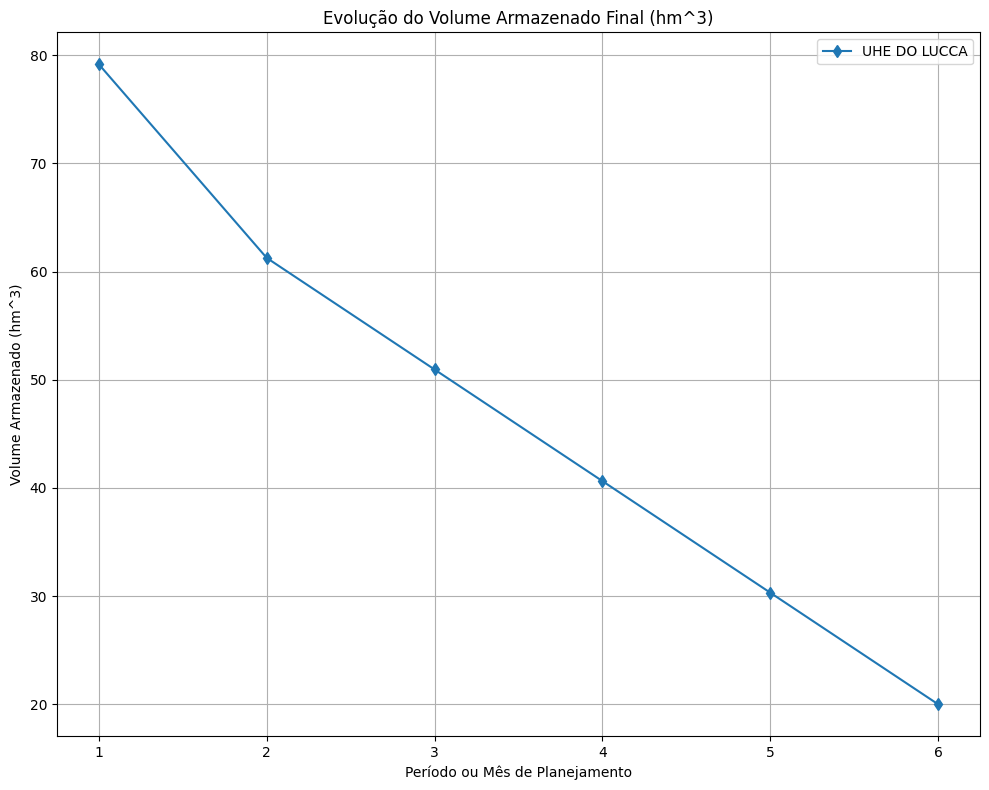

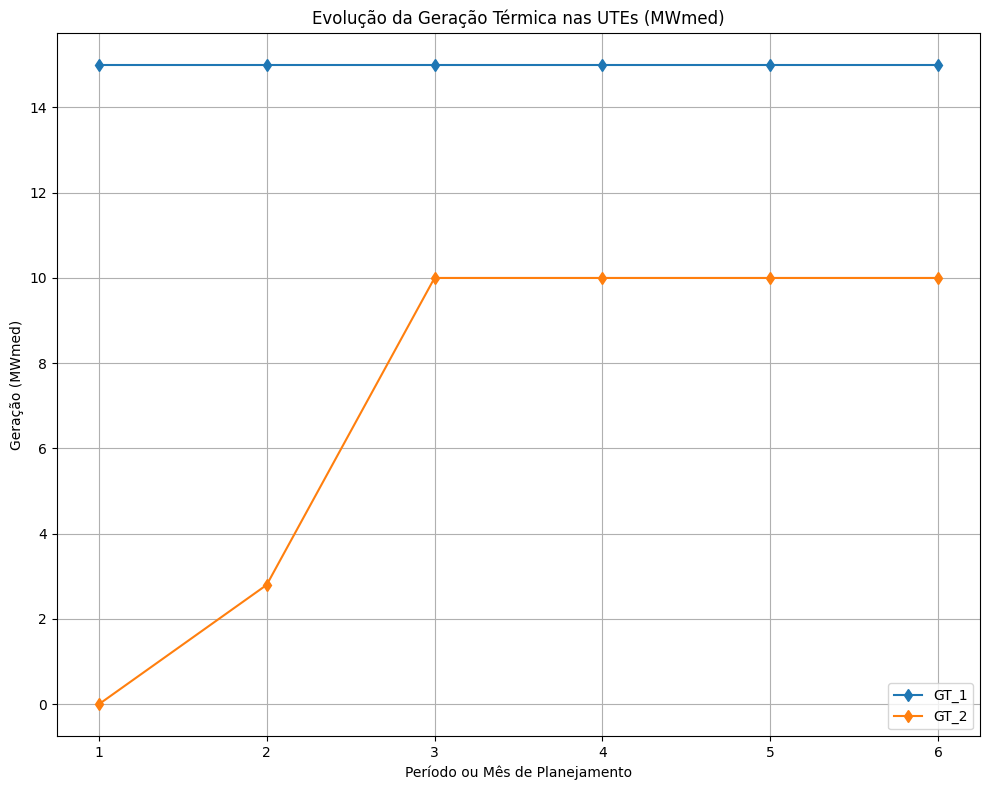

In [ ]:
resultado = pl_unico(sistema, 0, imprime=True)
